In [1]:
import numpy as np
import torch

# Loading maps

In [2]:
import mapping.utils as maps
import matplotlib.pyplot as plt

In [3]:
FILE = './data/file150.json' # Sample file

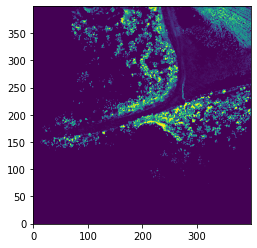

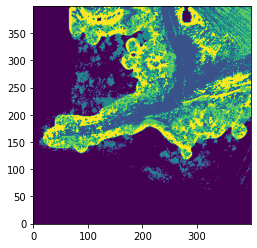

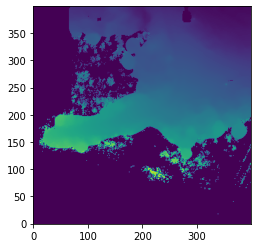

In [4]:
object_map, observed_map, terrain_map, origin_x, origin_y, resolution, num_x, num_y = maps.load_layers(FILE)

plt.imshow(object_map, origin ='lower')
plt.show()

plt.imshow(observed_map, origin ='lower')
plt.show()

plt.imshow(terrain_map, origin ='lower')
plt.show()

## Finding a path with a Rapidly-exploring Random Tree (RRT)

In [5]:
import sys
from pathlib import Path

PATH_TO_SHARED_LIB = str(Path("").resolve()) + "/rrt_sharp/src/rrt_sharp/build/"
sys.path.append(PATH_TO_SHARED_LIB)

from rrt_sharp_py import *

In [6]:
# Configure RRTSharp object

# Create Map dimension
rrt_sharp = RRTSharp([2, 3, 4])

rrt_sharp.set_map_info(origin_x, origin_y, resolution, num_x, num_y)
rrt_sharp.set_object_map(object_map.flatten().tolist())
rrt_sharp.set_observed_map(observed_map.astype(int).flatten().tolist())
rrt_sharp.set_terrain_map(terrain_map.flatten().tolist())
rrt_sharp.set_start_state(227.0, -143.0, 180.0)
rrt_sharp.set_goal_state(114.0, -250.0, 300.0)
rrt_sharp.set_stop_radius(5.0)

In [7]:
# Run RRT

rrt_sharp.init()
rrt_sharp.run()

Reached
Reached
Reached
Reached
Reached
Reached
Reached
Reached
Reached
numNodes: 4546, numChildren: 4546
total: 849.676 ms


# Simulating dynamics

In [5]:
import optimization.bicycle_model as bicycle_model
from optimization.utils import *
import optimization.quadratic as qr

## Simple example

In [6]:
model = bicycle_model.BicycleModelParameters(dt=0.02, max_steering_angle=2, min_steering_angle=-2, wheelbase=2.96)

# state: x, y, yaw, velocity

nx = 4
x0 = torch.tensor([0, 0, 0, 0.2]) # initial state

# controls: acceleration, steering_angle

nu = 2
U = torch.tensor([[2, 0], [1.2, 0.3], [1.4, 0.4], [0, 0.2]])

N = U.size(0)+1

# Simulate dynamics

params = OptimizationParameters(nx=nx, nu=nu, N=N, model=model)

# Caution: no constraints on the controls are handled by the forward pass/dynamics
X = simulate(x0, U, bicycle_model.discrete_dynamics, params)

print(X)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-01],
        [4.4000e-03, 0.0000e+00, 0.0000e+00, 2.4000e-01],
        [9.4400e-03, 6.3205e-06, 2.5081e-03, 2.6400e-01],
        [1.5000e-02, 3.1384e-05, 6.5075e-03, 2.9200e-01],
        [2.0840e-02, 6.9388e-05, 6.5075e-03, 2.9200e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])


## Using iLQR to follow reference trajectory

In [7]:
# problem size 
dt = model.dt 
tf = 5
t_vec = np.arange(0, tf, dt)

# create reference trajectory 
Xref, Uref = torch.zeros((N, nx)), torch.zeros((N-1, nu)) # TODO: generate non trivial reference trajectory

# tracking cost function
Q = torch.eye(nx)
R = torch.eye(nu)
Qf = 10*Q

# the params needed by iLQR 
qrParams = qr.QR(
    Q=Q,
    Qf=Qf,
    R=R,
    Xref=Xref,
    Uref=Uref,
    nx=params.nx,
    nu=params.nu,
    N=Xref.size(0),
    model=params.model
)

# initial condition 
x0 = Xref[0]

# initial guess controls 
U = Uref + .0001*torch.rand(Uref.size())

# solve with iLQR
X, U, K = qr.iLQR(x0, U, bicycle_model.discrete_dynamics, qrParams)

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor []], which is output 0 of AsStridedBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

## MPPI

In [8]:
from pytorch_mppi import MPPI
import gymnasium as gym
from gymnasium import spaces
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda


In [10]:
xg = torch.Tensor([300, 300])
x0 = torch.Tensor([150, 150, 0, 0.2])
cost_map = torch.Tensor(object_map)

u_min = torch.Tensor([-float('inf'), -2])
u_max = torch.Tensor([float('inf'),2])


model = bicycle_model.BicycleModelParameters(dt=1, max_steering_angle=90, min_steering_angle=-90, wheelbase=2.96)
params = OptimizationParameters(nx=nx, nu=nu, N=N, model=model)
def cost_fn(x, u):
    x = x.cpu().detach()
    if len(x.shape) > 1:
        x[:,:2] = x[:,:2].clamp(0,399)
        loc = x[:,:2].long()
        cost = torch.zeros(x.shape[0])
        for i in range(x.shape[0]):
            #cost[i] = cost_map[loc[i][0], loc[i][1]] + torch.norm(xg-loc[i])
            cost[i] = (cost_map[loc[i][0], loc[i][1]] * 100) + torch.norm(xg-loc[i], p=2)
    else:
        x[:2] = x[:2].clamp(0,399)
        loc = x[:2].long()
        #cost = cost_map[loc[0], loc[1]] + torch.norm(xg-loc)
        cost = (cost_map[loc[0], loc[1]] * 100) + torch.norm(xg-loc,p=2)
    return cost.to(device)

def dynamics_fn(x, u):
    return bicycle_model.discrete_dynamics(x,u,params)

class BikeEnv(gym.Env):
  #metadata = {'render.modes': ['human']}

    def __init__(self, nu, dynamics, params, cost_fn, cost_map, x0, xg):
        super(BikeEnv, self).__init__()
        max_dim = max(cost_map.shape)
        self.x0 = x0
        self.params = params
        self.state = x0
        self.xg = xg
        self.cost_map = cost_map
        self.dynamics = dynamics
        self.cost_fn = cost_fn
        self.action_space = spaces.Discrete(nu)
        self.observation_space = spaces.Box(low=0, high=max_dim, shape=cost_map.shape, dtype=np.uint8)
    def step(self, action):
        self.state = self.dynamics(self.state, action)
        observation = self.state
        reward = self.cost_fn(self.state, self.cost_map)
        return observation, reward, _, _

    def reset(self):
        self.state = self.x0
        return self.state # reward, done, info can't be included
  #def render(self, mode='human'):
  #  ...
  #def close (self):
  #|  ...

In [14]:
env = BikeEnv(nu, dynamics_fn, params, cost_fn, torch.Tensor(object_map), x0, xg)
controller = MPPI(env.dynamics, env.cost_fn, 4, torch.eye(2), device = device, num_samples=100)

In [15]:
obs = env.reset()
iterations = 100
path = torch.zeros([iterations, 4])
for i in range(iterations):
    action = controller.command(obs)
    obs, reward, _, _ = env.step(action)
    path[i] = obs

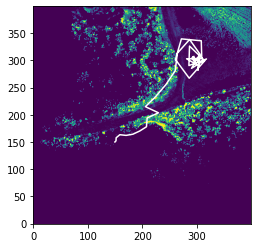

In [17]:
x = path[:,0]
y = path[:,1]

plt.imshow(object_map, origin ='lower')
plt.plot(x,y, color='w')
plt.show()